In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

In [4]:
quakes = pd.read_csv('Zemlya.csv', index_col=0)
quakes['x'] = quakes['x'].fillna(quakes['x'].mean())
quakes.isnull().sum()
df = quakes

In [5]:
df.describe()

,x
count,3048.000000
mean,2645.605643
std,7697.898862
min,-34522.000000
25%,-959.250000
50%,2588.500000
75%,6151.500000
max,42428.000000


In [6]:
df.head()

,x
1,-143
2,-114
3,4609
4,7309
5,3372


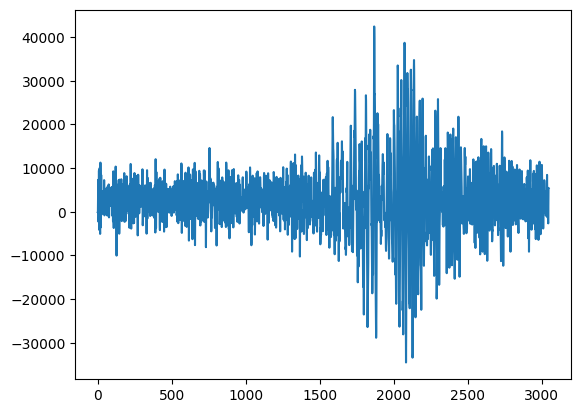

In [7]:
plt.plot(quakes['x'])

In [8]:
from statsmodels.tsa.stattools import adfuller

def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [9]:
df_test('Вертикальное ускорение сейсмографа в Кобе', df['x'])

Тест Дики-Фуллера ряда Вертикальное ускорение сейсмографа в Кобе:
Test Statistic                -1.498033e+01
p-value                        1.164672e-27
#Lags Users                    2.800000e+01
Number of Observations Used    3.019000e+03
Critical Value (1%)           -3.432518e+00
Critical Value (5%)           -2.862498e+00
Critical Value (10%)          -2.567280e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [10]:
df_test('Ускорение', df['x'])

Тест Дики-Фуллера ряда Ускорение:
Test Statistic                -1.498033e+01
p-value                        1.164672e-27
#Lags Users                    2.800000e+01
Number of Observations Used    3.019000e+03
Critical Value (1%)           -3.432518e+00
Critical Value (5%)           -2.862498e+00
Critical Value (10%)          -2.567280e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [16]:
nottrend = []
s = 6
notseason = []

# выборка без тренда
for i in range(1, len(df['x'])):
    nottrend.append(df['x'].iloc[i] - df['x'].iloc[i-1])

# выборка без сезонности
for i in range(s, len(df['x'])):
    notseason.append(df['x'].iloc[i] - df['x'].iloc[i-s])

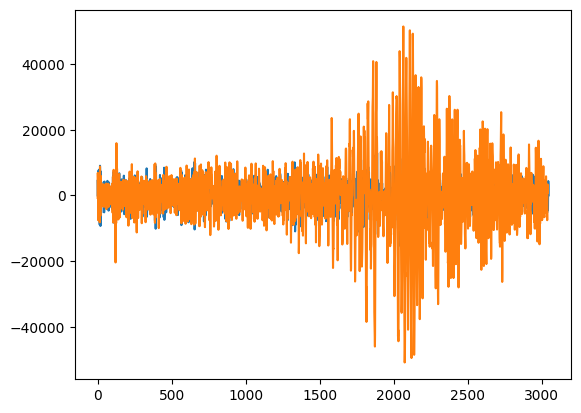

In [12]:
plt.plot(nottrend)
plt.plot(notseason)

In [13]:
df_test('не тренд', notseason)

Тест Дики-Фуллера ряда не тренд:
Test Statistic                  -21.247887
p-value                           0.000000
#Lags Users                      28.000000
Number of Observations Used    3013.000000
Critical Value (1%)              -3.432522
Critical Value (5%)              -2.862500
Critical Value (10%)             -2.567281
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [23]:
from scipy.stats import boxcox

# Shift the data to make it positive
min_value = np.min(df['x'])
shifted_data = df['x'] - min_value + 1  # Adding 1 to ensure all values are positive

# Apply the Box-Cox transformation
transformed_data, best_lambda = boxcox(shifted_data)

print(best_lambda)


1.1198733739212936


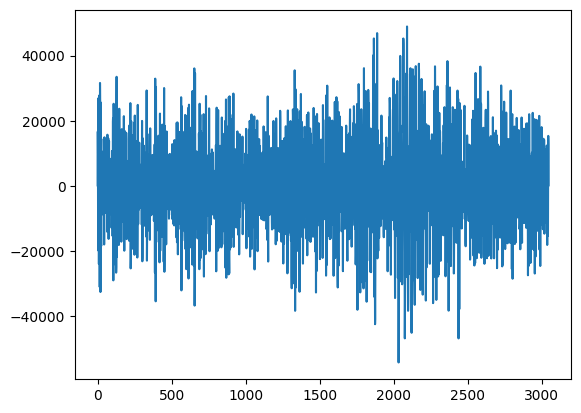

In [24]:
pnottrend = []

for i in range(1, len(transformed_data)):
    pnottrend.append(transformed_data[i] - transformed_data[i-1])

plt.plot(pnottrend)

In [25]:
df_test('Бокса-Кокса', pnottrend)

Тест Дики-Фуллера ряда Бокса-Кокса:
Test Statistic                  -20.369638
p-value                           0.000000
#Lags Users                      29.000000
Number of Observations Used    3017.000000
Critical Value (1%)              -3.432519
Critical Value (5%)              -2.862498
Critical Value (10%)             -2.567280
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


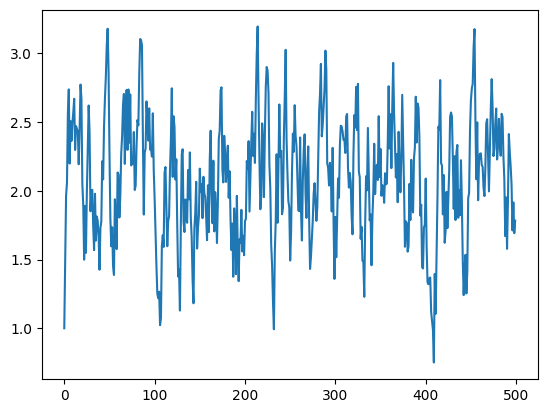

In [26]:
# AR(1)

N = 500

ar1 = [1]
ar1_minus = [1]
ar3 = [1]
for i in range(1, N):
    ar1.append(0.76 * ar1[i-1] + np.random.random())
    ar1_minus.append(-0.76 * ar1_minus[i-1] + np.random.random())
    ar3.append(2 * ar3[i-1] + np.random.random())



plt.plot(ar1)

In [27]:
print(f"standart deviation = {np.std(ar1)}\nmean = {np.mean(ar1)}")

standart deviation = 0.43145118536290816
mean = 2.086770296666657


In [28]:
def plot_ar1(name: list) -> None:
    ts = pd.DataFrame(name)

    fig = plt.figure(figsize=(20, 9))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    ts.plot(ax=ts_ax)
    ts_ax.set_title('Time Series Analysis Plots')
    smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(ts, lags=20, ax=pacf_ax, alpha=0.5)

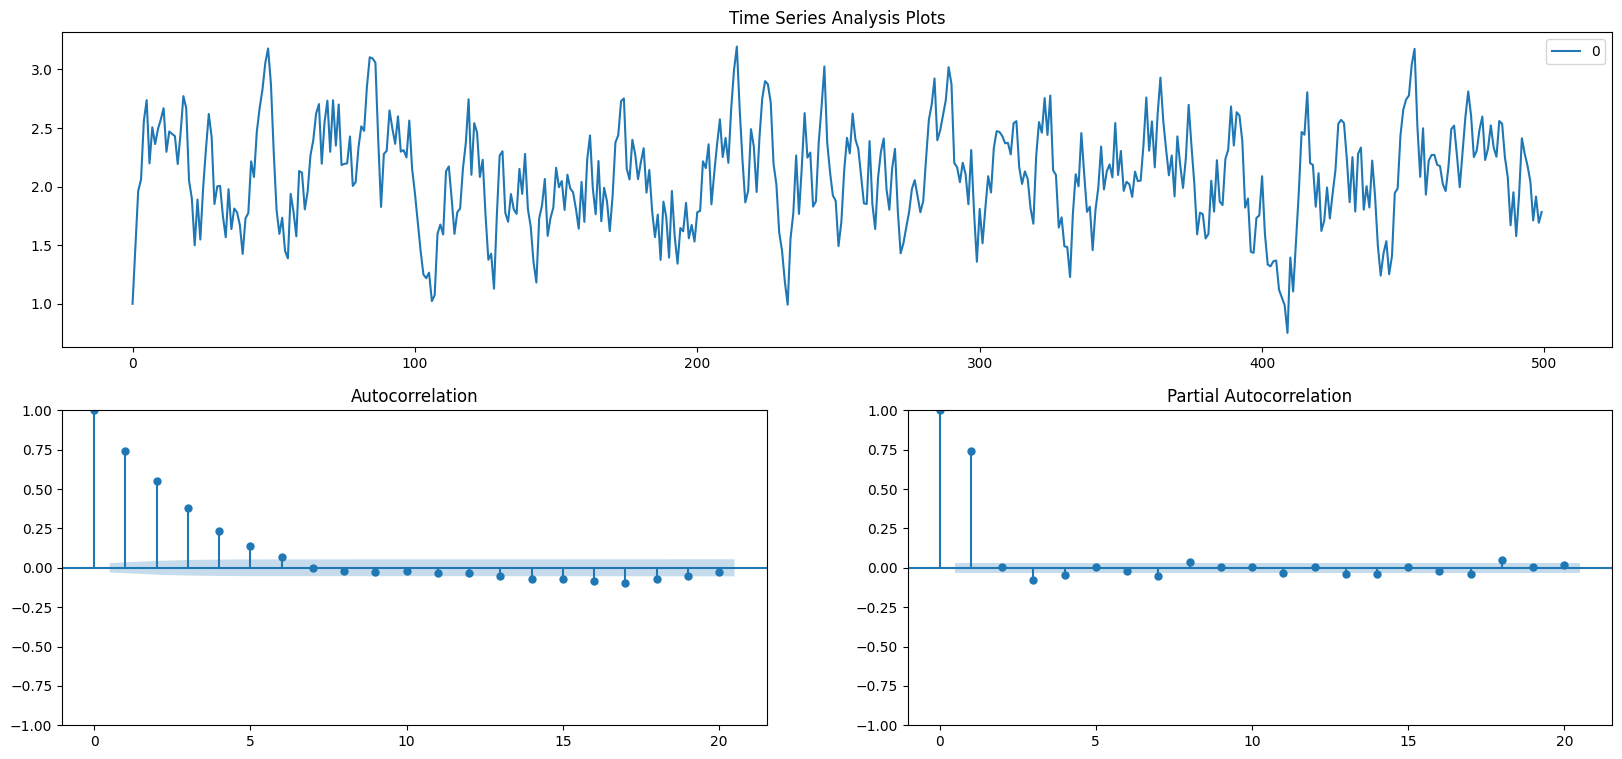

In [29]:
plot_ar1(ar1)

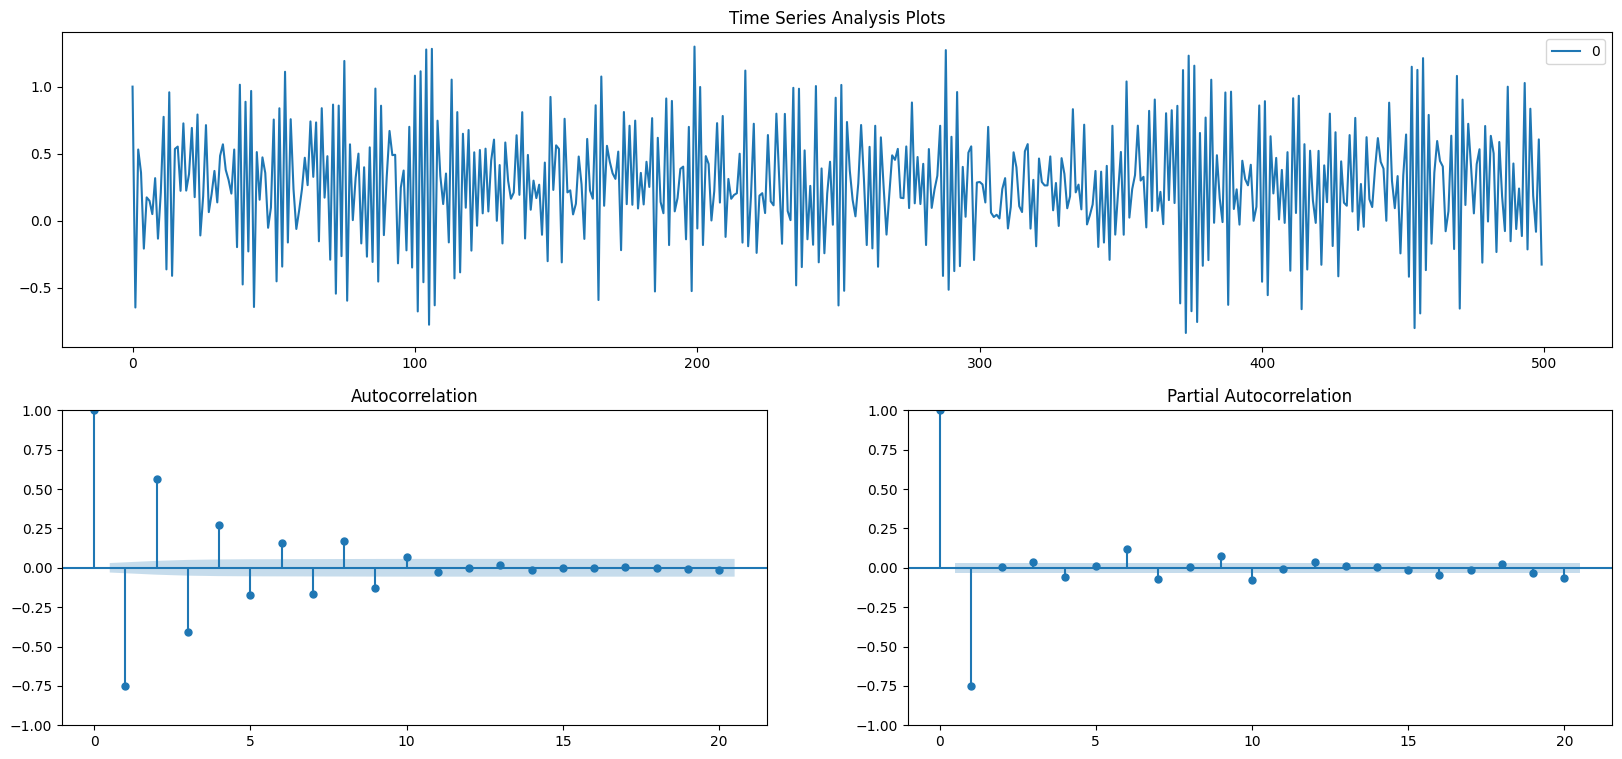

In [30]:
plot_ar1(ar1_minus)

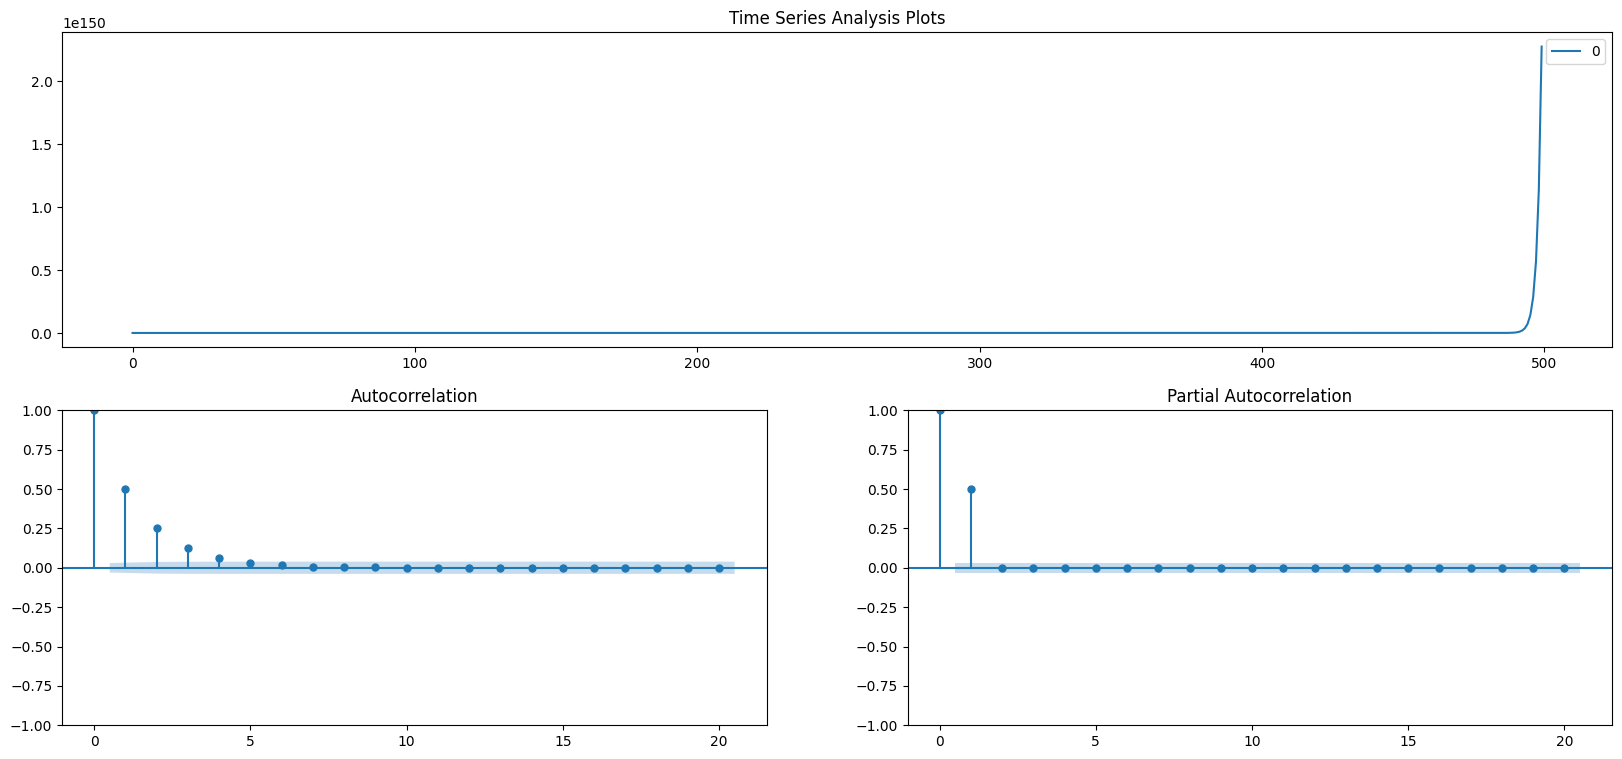

In [31]:
plot_ar1(ar3)

In [33]:
df = pd.read_csv('Zemlya.csv',
                 names=['n', 'x'], skiprows=1)
df['x'] = df['x'].fillna(df['x'].mean())

df['t'] = df.index.values

ln = len(df)

# указываем 'объёмы' выборок
train_cutoff = int(round(ln * 0.75, 0))
validate_cutoff = int(round(ln * 0.90, 0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

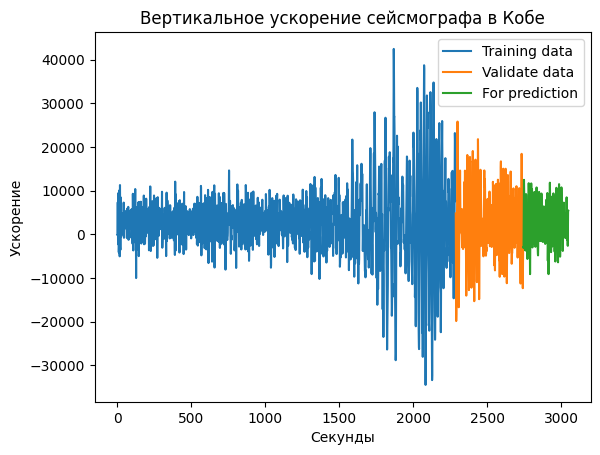

In [34]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.legend()
plt.title('Вертикальное ускорение сейсмографа в Кобе')
plt.ylabel('Ускорение')
plt.xlabel('Секунды')
plt.show()

In [35]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [36]:
mod = AutoReg(df.t, 3, old_names=False)
res = mod.fit()

print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                 3048
Model:                     AutoReg(3)   Log Likelihood               63102.598
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Fri, 03 Nov 2023   AIC                        -126195.196
Time:                        14:07:28   BIC                        -126165.089
Sample:                             3   HQIC                       -126184.375
                                 3048                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667   2.92e-12   2.28e+11      0.000       0.667       0.667
t.L1           1.0000   2.92e-12   3.42e+11      0.000       1.000       1.000
t.L2           0.3333   1.66e-15   2.01e+14      0.0

In [37]:
sel = ar_select_order(df.x, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                 3048
Model:                    AutoReg(13)   Log Likelihood              -23235.659
Method:               Conditional MLE   S.D. of innovations            511.303
Date:                Fri, 03 Nov 2023   AIC                          46501.318
Time:                        14:07:49   BIC                          46591.587
Sample:                            13   HQIC                         46533.769
                                 3048                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        211.7094     14.673     14.428      0.000     182.951     240.468
x.L1           3.8878      0.018    216.768      0.000       3.853       3.923
x.L2          -8.9426      0.070   -126.859      0.0

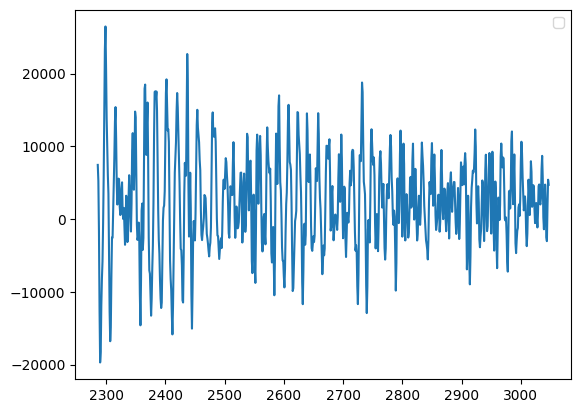

In [38]:
# смотрим, что предсказал
fig = res.plot_predict(train_cutoff)

In [39]:
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff+1, end=(forecast_df.t[len(df.t) - 1]), dynamic=False)

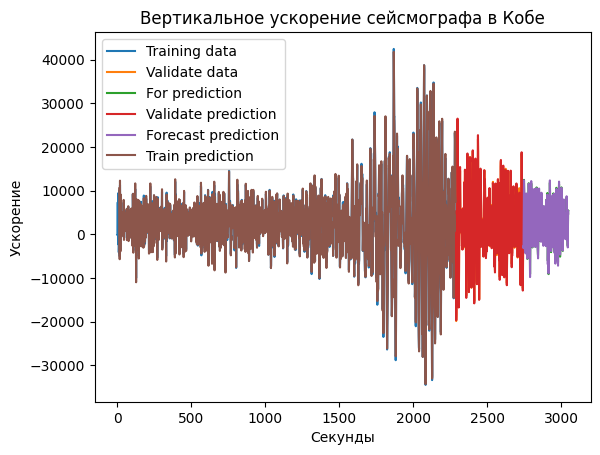

In [40]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.plot(validate_df.t, v_pred, label='Validate prediction')
plt.plot(forecast_df.t, f_pred, label='Forecast prediction')
plt.plot(train_df.t, pred, label='Train prediction')

plt.legend()
plt.title('Вертикальное ускорение сейсмографа в Кобе')
plt.ylabel('Ускорение')
plt.xlabel('Секунды')
plt.show()

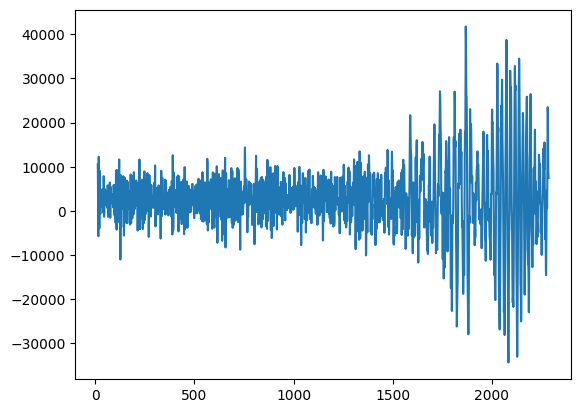

In [41]:
plt.plot(pred)

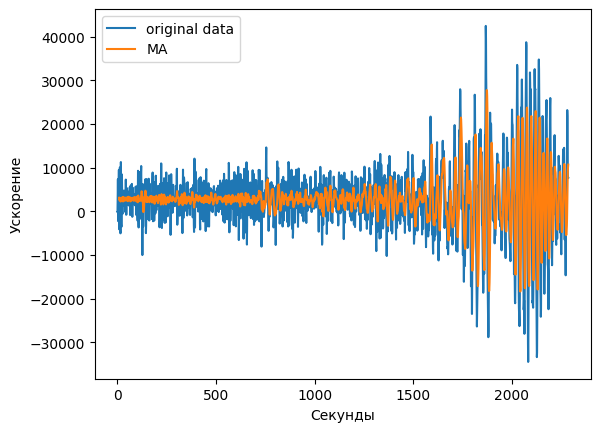

In [43]:
# MA

df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

plt.plot(train_df["t"], train_df["x"], label="original data")
plt.plot(train_df["t"], train_df["x"].rolling(10).mean(), label="MA")
plt.legend()
plt.ylabel('Ускорение')
plt.xlabel('Секунды')
plt.show()

In [44]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [45]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2: ", r2_score(forecast_df.x, f_pred))

RMSE: 404.50143196549834
MAPE: 0.40147765331752366
MAE: 323.9626626549523
R2:  0.9908276596648246
